In [1]:
import sys
if ".." not in sys.path:
    sys.path.append("..")

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import wandb

from functools import partial

from src.display import showarray
from src.mask import MaskGenerator
from src.datagen import DatasetFillGenerator

In [2]:
wandb.init(project="test-project", entity="put_dl_team")
wandb.config = {
  "learning_rate": 0.001,
  "epochs": 10,
  "batch_size": 32,
  "mask_gen_degree": "LIGHT",
  "mask_gen_min_width": 10,
  "mask_gen_max_width": 20,
}

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sbartekt (put_dl_team). Use `wandb login --relogin` to force relogin


In [3]:
IMAGE_SIZE = (256, 256)
CHANNELS = 3
BATCH_SIZE = wandb.config["batch_size"]

MASK_GEN_PARAM = {
    "degree": wandb.config["mask_gen_degree"],
    "min_width": wandb.config["mask_gen_min_width"],
    "max_width": wandb.config["mask_gen_max_width"],
}

mask_generator = MaskGenerator(*IMAGE_SIZE, CHANNELS, **MASK_GEN_PARAM)

def mask_image_augment(images: tf.Tensor, mask_generator: MaskGenerator, max_val: float) -> tf.Tensor:
    masks = mask_generator(images.shape[0])
    augmented = tf.where(masks == 0, images, 1) 
    return augmented

gen_mask_image_augment = partial(mask_image_augment, mask_generator=mask_generator, max_val=1.)

In [4]:
def scale(x):
    return x / 255.0

def recast_to_image(tensor: tf.Tensor) -> np.ndarray:
    return tf.cast(tensor * 255, tf.uint8).numpy()


ds_train, ds_valid = tf.keras.preprocessing.image_dataset_from_directory(
    directory="../data/all", label_mode=None, image_size=IMAGE_SIZE, batch_size=BATCH_SIZE,
    shuffle=True, seed=42, validation_split=0.1, subset="both",
)
ds_train = ds_train.map(scale)
ds_valid = ds_valid.map(scale)

Found 17507 files belonging to 1 classes.
Using 15757 files for training.
Using 1750 files for validation.


In [5]:
np.random.seed(42)
train_generator = DatasetFillGenerator(ds_train, IMAGE_SIZE, CHANNELS, gen_mask_image_augment)
valid_generator = DatasetFillGenerator(ds_valid, IMAGE_SIZE, CHANNELS, gen_mask_image_augment)

In [8]:
# dummy model for preview
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape=(*IMAGE_SIZE, 3)))
model.add(tf.keras.layers.Conv2D(32, 5, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(32, 5, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Conv2D(32, 5, padding="same", activation="relu"))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(32, activation="relu"))
model.add(tf.keras.layers.Dense(3 * IMAGE_SIZE[0] * IMAGE_SIZE[1], activation="sigmoid"))
model.add(tf.keras.layers.Reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.MeanSquaredError(),
)

class ImageFillCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        batch_masks, batch_images = train_generator[1]
        nn_filled = model.predict(batch_images)
        all_joint = []
        for i in range(5):
            masked = recast_to_image(batch_masks[i])
            original_image = recast_to_image(batch_images[i])
            filled_image = recast_to_image(nn_filled[i])
            joint = np.concatenate([masked, original_image, filled_image], axis=1)
            all_joint.append(joint)
        all_joint = np.concatenate(all_joint, axis=0)
        wandb.log({"sample_fill": wandb.Image(all_joint)})


model.fit(valid_generator, epochs=10, callbacks=[wandb.keras.WandbCallback(), ImageFillCallback()]) # used valid_generator for faster training as this is just a preview

Epoch 1/10
55/55 [==============================] - 146s 3s/step - loss: 0.0724
Epoch 2/10
55/55 [==============================] - 172s 3s/step - loss: 0.0594
Epoch 3/10
55/55 [==============================] - 170s 3s/step - loss: 0.0490
Epoch 4/10
55/55 [==============================] - 173s 3s/step - loss: 0.0426
Epoch 5/10
55/55 [==============================] - 180s 3s/step - loss: 0.0382
Epoch 6/10
55/55 [==============================] - 172s 3s/step - loss: 0.0358
Epoch 7/10
55/55 [==============================] - 171s 3s/step - loss: 0.0345
Epoch 8/10
55/55 [==============================] - 163s 3s/step - loss: 0.0337
Epoch 9/10
55/55 [==============================] - 165s 3s/step - loss: 0.0339
Epoch 10/10
55/55 [==============================] - 164s 3s/step - loss: 0.0326


1/1 [==============================] - 0s 223ms/step


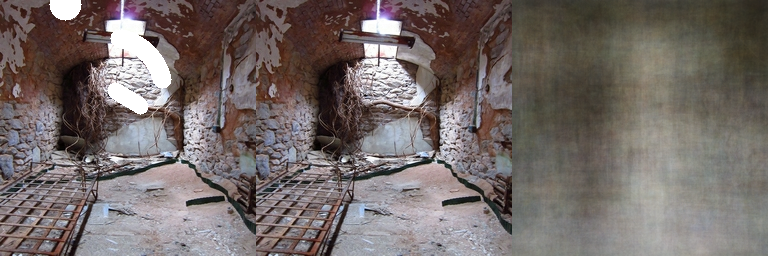

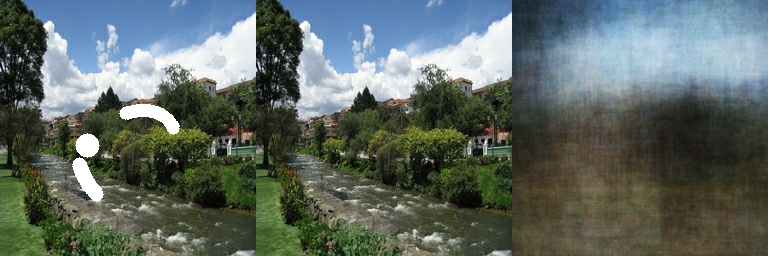

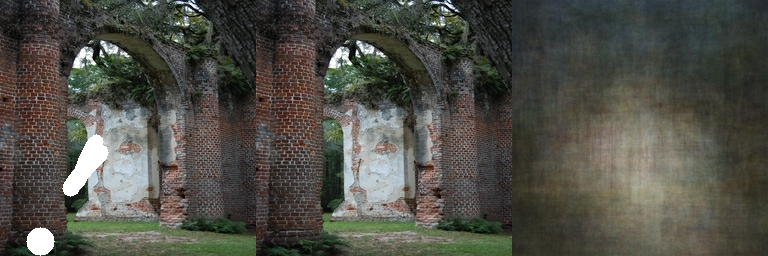

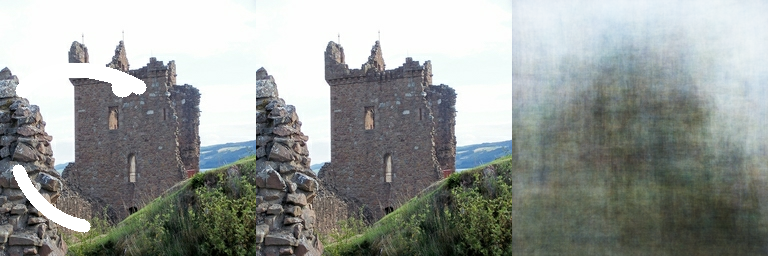

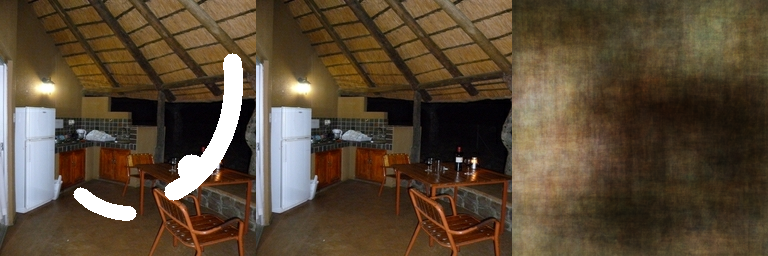

In [9]:

batch_masks, batch_images = train_generator[1]
nn_filled = model.predict(batch_images)
for i in range(5):
    masked = recast_to_image(batch_masks[i])
    original_image = recast_to_image(batch_images[i])
    filled_image = recast_to_image(nn_filled[i])
    
    showarray(np.concatenate([masked, original_image, filled_image], axis=1), converted=None)